In the original DINOv2 repo, foreground/background thresholding on the 1st component of the PCA was done by ignoring the negative components (when the PCA was normalised). However, they also mention on the Github that there can be an arbritrary sign change (i.e the threshold might be all components < 0 rather than > 0). One idea I had was to choose which sign to use by selecting the threshold that has the highest entropy per area, under the assumption the subject of the image will have a higher entropy than the background. It's normalised by area to in the case that the foreground object is small. 

This could of course be adapted to not just threshold at 0, *i.e,* to find the sign and the threshold that best optimizes the entropy per area, but that might take a while.

In [1]:
# Imports
import torch
torch.cuda.empty_cache()

from utils import *
import numpy as np
from PIL import Image
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from typing import Tuple, List, Any, TypedDict

IMG_SIZE = 518
PATCH_SIZE  = 14
PATCH_H, PATCH_W = IMG_SIZE // PATCH_SIZE, IMG_SIZE // PATCH_SIZE
FEAT_DIM = 384

transform = get_input_transform(520, IMG_SIZE)

In [2]:
from high_res import HighResDV2

shifts = [1, 2, 3, 4, 5, 6, 7]
net = HighResDV2("dinov2_vits14", shifts, pattern="Moore", dtype=torch.float32, pca_each=False)
net.cuda()
net.eval()
pass

Using cache found in /home/ronan/.cache/torch/hub/facebookresearch_dinov2_main
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:43: UserWarning: xFormers is available (SwiGLU)
  warnings.warn("xFormers is available (SwiGLU)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:27: UserWarning: xFormers is available (Attention)
  warnings.warn("xFormers is available (Attention)")
/home/ronan/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:33: UserWarning: xFormers is available (Block)
  warnings.warn("xFormers is available (Block)")


We compute the local entropy - the entropy around a disk kernel radius *k* for each pixel in the greyscale image. The choice of *k* is arbritrary, it can be set low like 10 but I've found more success setting it to 50 for difficult images. The local entropy can be tricked by high frequency backgrounds like grass, but this affect is ameliorated by having a larger kernel (seemingly w/out loss of performance on easy images).

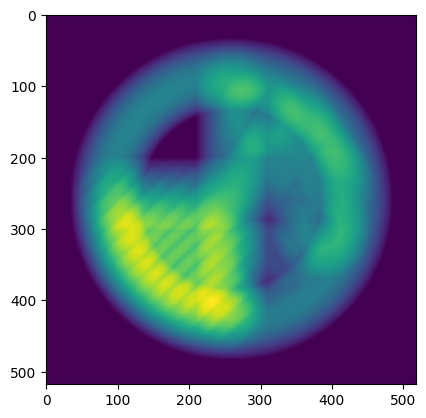

In [3]:
test_tensor, test_img = load_image("data/test_image_centred.png", transform)
test_tensor = test_tensor.to('cuda')
test_arr = np.array(test_img.convert('L'))
entropy_img = get_entropy_img(test_arr, 50)
plt.imshow(entropy_img)

In [4]:
high_res_features, low_res_features = net(test_tensor)

In [5]:
feat_arr = to_numpy(high_res_features)
feat_arr = feat_arr.reshape((net.feat_dim, IMG_SIZE * IMG_SIZE))
feat_arr = feat_arr.T

pca = do_single_pca(feat_arr)
_, _, mask = threshold_pca(feat_arr, pca, 0, True, True)
mask = mask.reshape(IMG_SIZE, IMG_SIZE)

1.6878272153113312 1.1056803656735072


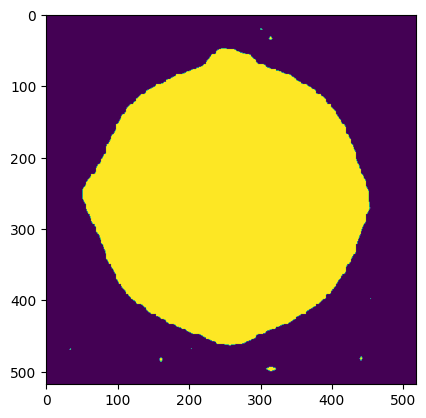

In [6]:
masks = [mask, ~mask]

threshold_1_entropy = entropy_per_area(mask, entropy_img)
threshold_2_entropy = entropy_per_area(~mask, entropy_img)
print(threshold_1_entropy, threshold_2_entropy)

best_mask_idx = np.argmax([threshold_1_entropy, threshold_2_entropy])
best_mask = masks[best_mask_idx]
plt.imshow(best_mask)

We look at a selection of images, find the best threshold and plot.

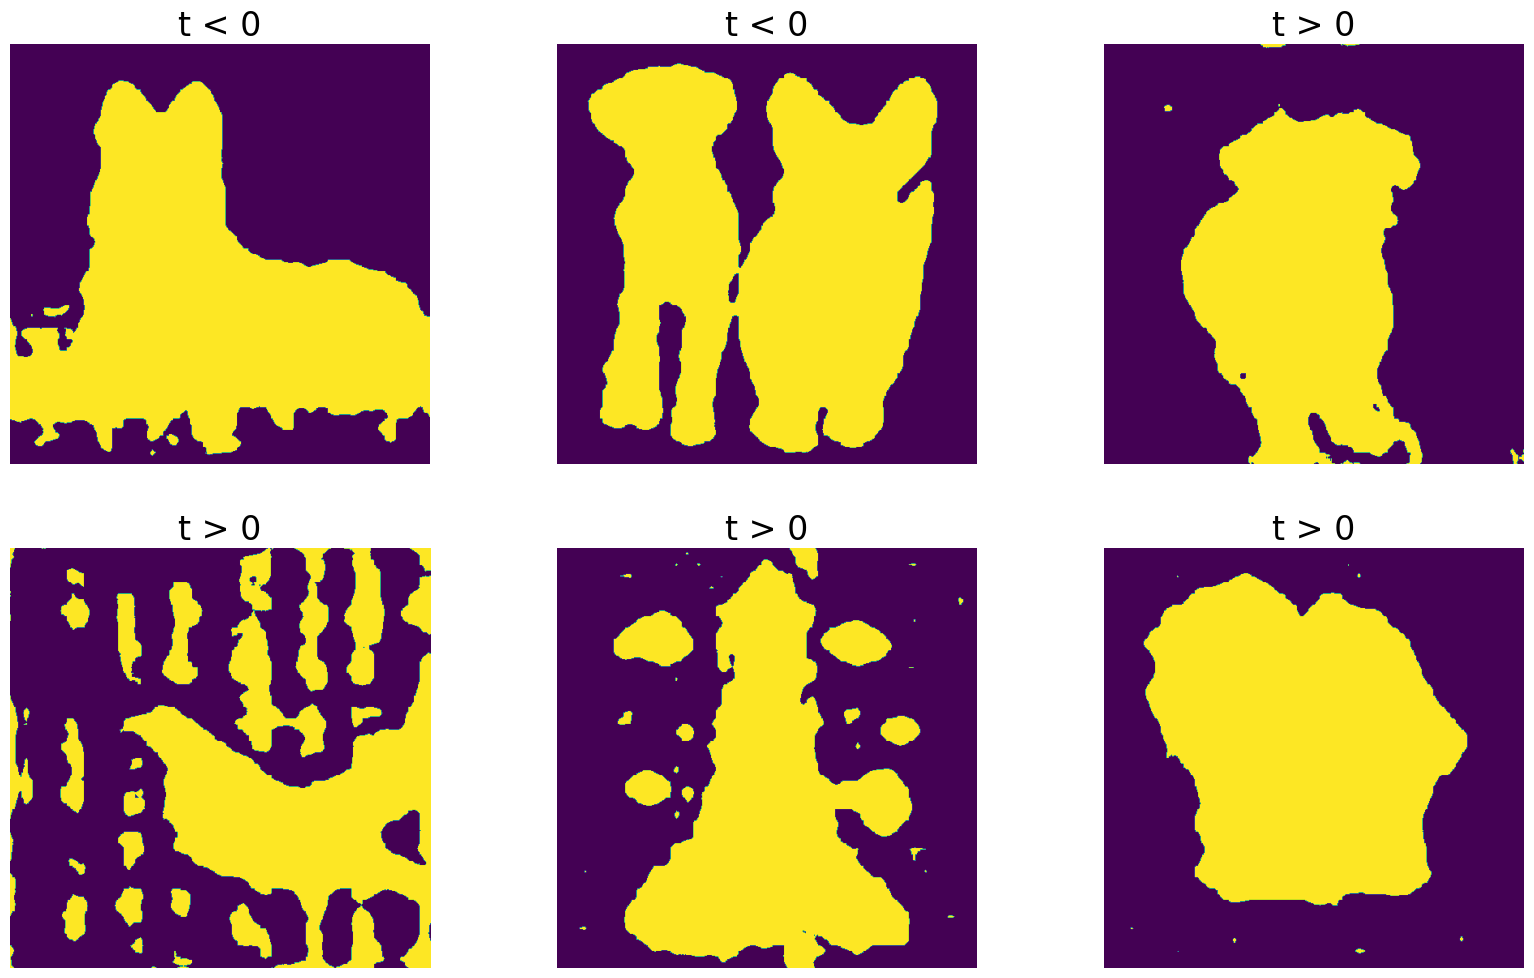

In [7]:
img_paths = ["d1.jpg", "d2.jpg", "d3.jpg", "plane.jpg", "sketch.jpg", "test_image.png"]


fig, axs = plt.subplots(nrows=2, ncols=3)
fig.set_size_inches(20, 12)
titles = ["t > 0", "t < 0"]
for i, path in enumerate(img_paths):
    tensor, img = load_image(f"data/{path}", transform)
    tensor = tensor.cuda()
    high_res_features, _ = net(tensor)
    feat_arr = flatten(high_res_features, IMG_SIZE, IMG_SIZE, net.feat_dim, True)
    grey_img_arr = np.array(img.convert("L"))
    best_mask, best_mask_idx = get_best_mask(feat_arr, grey_img_arr, 50)
    
    ax = axs[i // 3, i % 3]
    ax.imshow(best_mask)
    ax.set_title(titles[best_mask_idx], fontsize=24)
    ax.set_axis_off()